# 1.Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

# 2.Data 

## 2.1 Loaders

### 2.1.1 MNIST Data

In [34]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

train_dataloader = DataLoader(train_data,batch_size=batch_size,
    shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [43]:

subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(train_data, [subset_size, len(train_data) - subset_size])
    subset_loader = DataLoader(subset, batch_size=32, shuffle=True)
    subset_loaders.append(subset_loader)


## 2.2 Data shape

In [4]:
for images,labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## 3.Model

In [5]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x

# 4.Training

In [25]:
def train(epochs:int,model,optimizer,criterion,data):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()

            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)} , loss: {loss.item():.4f}')
        loss_history.append(loss.item())
            
    print('Finished training!')
    return loss_history

In [53]:
model = Fcnn()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train(3,model,optimizer,criterion,train_dataloader)

epoch: 1, step: 100/3750 , loss: 1.8908
epoch: 1, step: 200/3750 , loss: 1.7894
epoch: 1, step: 300/3750 , loss: 1.5904
epoch: 1, step: 400/3750 , loss: 1.7767
epoch: 1, step: 500/3750 , loss: 1.6523
epoch: 1, step: 600/3750 , loss: 1.6694
epoch: 1, step: 700/3750 , loss: 1.6568
epoch: 1, step: 800/3750 , loss: 1.7092
epoch: 1, step: 900/3750 , loss: 1.5276
epoch: 1, step: 1000/3750 , loss: 1.6782
epoch: 1, step: 1100/3750 , loss: 1.5820
epoch: 1, step: 1200/3750 , loss: 1.5494
epoch: 1, step: 1300/3750 , loss: 1.4786
epoch: 1, step: 1400/3750 , loss: 1.5354
epoch: 1, step: 1500/3750 , loss: 1.5785
epoch: 1, step: 1600/3750 , loss: 1.5732
epoch: 1, step: 1700/3750 , loss: 1.6300
epoch: 1, step: 1800/3750 , loss: 1.5348
epoch: 1, step: 1900/3750 , loss: 1.6057
epoch: 1, step: 2000/3750 , loss: 1.5254
epoch: 1, step: 2100/3750 , loss: 1.5164
epoch: 1, step: 2200/3750 , loss: 1.5454
epoch: 1, step: 2300/3750 , loss: 1.5258
epoch: 1, step: 2400/3750 , loss: 1.5317
epoch: 1, step: 2500/3750

## 5.Testing

In [42]:
def test(model, data):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            output = model(images)

            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(data.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


In [14]:

test(model)
        

Accuracy: 0.970


## 6. Early stopping

In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train_es(epochs:int,model,optimizer,criterion):
    early_stopper = EarlyStopper(patience=2, min_delta=10)
    model.train()
    for epoch in range(epochs):
        for batch, (images,labels) in enumerate(train_dataloader):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels)
            loss.backward()

            optimizer.step()
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(train_dataloader)} , loss: {loss.item():.4f}')

            if early_stopper.early_stop(loss.item()):
                print('Early stopping!')
                break
    print('Finished training!')



In [13]:
model = Fcnn()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_es(10,model,optimizer,criterion)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/938 , loss: 1.7951
epoch: 1, step: 200/938 , loss: 1.8284
epoch: 1, step: 300/938 , loss: 1.6916
epoch: 1, step: 400/938 , loss: 1.8413
epoch: 1, step: 500/938 , loss: 1.7176
epoch: 1, step: 600/938 , loss: 1.6733
epoch: 1, step: 700/938 , loss: 1.6169
epoch: 1, step: 800/938 , loss: 1.7116
epoch: 1, step: 900/938 , loss: 1.5949
epoch: 2, step: 100/938 , loss: 1.6803
epoch: 2, step: 200/938 , loss: 1.6585
epoch: 2, step: 300/938 , loss: 1.6134
epoch: 2, step: 400/938 , loss: 1.6117
epoch: 2, step: 500/938 , loss: 1.5930
epoch: 2, step: 600/938 , loss: 1.6567
epoch: 2, step: 700/938 , loss: 1.6043
epoch: 2, step: 800/938 , loss: 1.5342
epoch: 2, step: 900/938 , loss: 1.5361
epoch: 3, step: 100/938 , loss: 1.5304
epoch: 3, step: 200/938 , loss: 1.5504
epoch: 3, step: 300/938 , loss: 1.5418
epoch: 3, step: 400/938 , loss: 1.5521
epoch: 3, step: 500/938 , loss: 1.5111
epoch: 3, step: 600/938 , loss: 1.5544
epoch: 3, step: 700/938 , loss: 1.4957
epoch: 3, step: 800/938 ,

In [44]:
criterion = nn.CrossEntropyLoss()

subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []
for subset in subset_loaders:
    model = Fcnn()
    optimizer = torch.optim.Adam(model.parameters())
    loss_history = train(3,model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(model,test_dataloader)
    accuracy_train = test(model,train_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training!
Accuracy: 0.685
Accuracy: 0.683
Finished training!
Accuracy: 0.791
Accuracy: 0.780
Finished training!
Accuracy: 0.719
Accuracy: 0.710
epoch: 1, step: 100/125 , loss: 1.8584
epoch: 2, step: 100/125 , loss: 1.6340
epoch: 3, step: 100/125 , loss: 1.6458
Finished training!
Accuracy: 0.818
Accuracy: 0.812
epoch: 1, step: 100/157 , loss: 1.7036
epoch: 2, step: 100/157 , loss: 1.7441
epoch: 3, step: 100/157 , loss: 1.5964
Finished training!
Accuracy: 0.840
Accuracy: 0.843


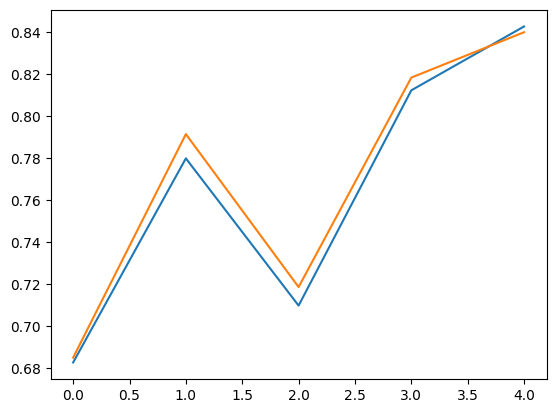

In [45]:
plt.plot(subset_accuracy_train, label='Train accuracy')
plt.plot(subset_accuracy_test, label='Test accuracy')
# subset_accuracy_test